In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import time
import copy
from tabulate import tabulate

In [2]:
sales_original = pd.read_csv("in/tables/DynamicalClustering_sales_full.csv")
sales_original.SalesDate = pd.to_datetime(sales_original.SalesDate)

In [3]:
# sales_original = sales_original.loc[(sales_original.SalesDate >= '2019-10-25') & (sales_original.SalesDate < '2020-01-01')]
sales_original = sales_original.loc[(sales_original.SalesDate >= '2020-01-07') & (sales_original.SalesDate < '2020-10-25')]
# sales_original = sales_original.loc[(sales_original.SalesDate >= '2019-10-25') & (sales_original.SalesDate < '2020-10-25')]
# sales_original = sales_original.loc[(sales_original.SalesDate >= '2020-01-07') | (sales_original.SalesDate < '2020-01-01')]

In [4]:
volumes_original = pd.read_csv("in/tables/DynamicalClustering_volumes_past.csv")
volumes_original['Cartons'] = round(volumes_original['Percent_fullness'] * 1.1, 4)
volumes_dict = dict(volumes_original[["Product_ID","Cartons"]].values)

In [5]:
sales_original

,Product_SK,ProductSKU_SK,Product_ID,EcommOrderNumber,SalesQty,SalesDate,DayOfWeek
4,23777,118834,23777.0,50531293035,1,2020-05-05,2
5,42980,213462,NaN,270732676881,1,2020-07-27,1
8,71166,333752,NaN,50531293029,1,2020-05-05,2
10,83151,438656,83151.0,80631859701,1,2020-06-08,1
13,81990,428724,81990.0,150832910631,1,2020-08-15,6
...,...,...,...,...,...,...,...
10581069,71514,336944,NaN,40430708417,1,2020-04-04,6
10581077,109744,505700,109744.0,10531212287,1,2020-05-01,5
10581078,34549,172446,34549.0,231033897297,1,2020-10-23,5
10581081,83710,442593,NaN,120430938067,1,2020-04-12,0


In [6]:
volumes_original

,Product_SK,Product_ID,Cartons,Percent_fullness,PhysicalQty
0,140,140,0.3960,0.36000,12
1,524,10001934,0.9465,0.86046,31
2,543,543,0.0328,0.02982,2
3,889,10003183,0.7204,0.65489,28
4,1109,10004469,0.6733,0.61206,26
...,...,...,...,...,...
51481,246398,10952269,0.5259,0.47807,15
51482,246405,10952352,0.8760,0.79640,25
51483,246424,10952281,0.2434,0.22127,1
51484,103301,103301,1.3200,1.20000,1


In [7]:
cluster_size = 330

In [8]:
print("Product in stock:                ",len(volumes_original))
print("Product in orders:               ",len(set(sales_original[sales_original.Product_ID.notnull()].Product_ID)))
print("Product in stock & orders:       ",len(volumes_original[volumes_original.Product_ID.isin(list(set(sales_original[sales_original.Product_ID.notnull()].Product_ID)))]))
print("Product in orders & not in stock: ", len(list(set(sales_original[sales_original.Product_ID.notnull()].Product_ID))) -
      len(set(sales_original[sales_original.Product_ID.isin(list(set(volumes_original.Product_ID)))].Product_ID)))

Product in stock:                 51486
Product in orders:                45249
Product in stock & orders:        32314
Product in orders & not in stock:  12935


In [9]:
print("Volume of products in stock:      ",sum(volumes_original.Cartons))

Volume of products in stock:       20410.01630000003


In [10]:
print("Volume of products in orders:     ",sum(list(map(lambda product: volumes_dict[product], filter(lambda product: product in volumes_dict.keys(), set(sales_original[sales_original.Product_ID.notnull()].Product_ID))))))

Volume of products in orders:      12380.091599999821


In [11]:
print("Volume of products not in orders: ",sum(list(map(lambda product: volumes_dict[product], set(volumes_original.Product_ID) - set(sales_original[sales_original.Product_ID.notnull()].Product_ID)))))

Volume of products not in orders:  8029.924699999731


In [12]:
print(len(volumes_original.Product_ID))
print(len(set(volumes_original.Product_ID)))

51486
51486


In [13]:
transports_total_number = math.ceil(sum(volumes_original.Cartons)/cluster_size)
transports_with_products_in_orders_total_number = math.ceil(sum(list(map(lambda product: volumes_dict[product], filter(lambda product: product in volumes_dict.keys(), set(sales_original[sales_original.Product_ID.notnull()].Product_ID)))))/cluster_size)

print("Transports total:                        ", transports_total_number)
print("Transports with products in orders:      ",transports_with_products_in_orders_total_number)

Transports total:                         62
Transports with products in orders:       38


In [14]:
orders = sales_original["EcommOrderNumber"].unique()

In [15]:
def generate_common_ordered_products():
    common_ordered_products = {}

    for order_number in orders:
        order_products = list(filter(lambda product: product in volumes_dict.keys(), list(sales_original[sales_original["EcommOrderNumber"] == order_number]["Product_ID"].unique())))
        for order_product in order_products:
            if order_product not in common_ordered_products.keys():
                common_ordered_products[order_product] = set()
            for x in order_products:
                if x != order_product: common_ordered_products[order_product].add(x)
    return common_ordered_products

In [16]:
def compute_volume_of_common_products(main_product, products):
    return volumes_dict[main_product] + sum(list(map(lambda product: volumes_dict[product], products)))

In [17]:
def pick_products_to_cluster(products, size):
    cluster_volume = 0
    picked_products = []
    picked_products_all = []
    
    #TODO final condition check products empty?
    while size - cluster_volume > 0 and products:
        picked_product = max(products, key=lambda product: product.get('Volume'))
        if picked_product.get('Volume') > size - cluster_volume:
            products_bin_volume = 0
            products_bin = []
            
            products_bin.append(picked_product.get('Product_SK'))
            products_bin_volume += volumes_dict[picked_product.get('Product_SK')]
            sorted_common_products_by_volume = sorted(list(picked_product.get('Common_products')), key=lambda product: volumes_dict[product], reverse=True)

            while size - cluster_volume - products_bin_volume > 0:
                product = sorted_common_products_by_volume.pop(0)
                products_bin.append(product)
                products_bin_volume += volumes_dict[product]
            
            cluster_volume += products_bin_volume
            picked_products_all.extend(products_bin)
            
        if picked_product.get('Volume') <= size - cluster_volume:
            cluster_volume += picked_product.get('Volume')
            picked_products.append(picked_product)
            picked_products_all.append(picked_product.get('Product_SK'))
            for product in picked_product.get('Common_products'):
                picked_products_all.append(product)
            
            for x in products:
                if picked_product.get('Product_SK') in x.get('Common_products'):
                    x['Common_products'].remove(picked_product.get('Product_SK'))
                    x['Volume'] = compute_volume_of_common_products(x.get('Product_SK'), x.get('Common_products'))
                    if x['Volume'] == 0:
                        products.remove(x)
            products.remove(picked_product)
            for product in picked_product.get('Common_products'):
                if product in list(map(lambda x: x.get('Product_SK'), products)):
                    x = list(filter(lambda y: y.get('Product_SK') == product, products))[0]
                    products.remove(x)
    #         print(f'Clustore volume: {cluster_volume}')
    #         print(f'Products len: {len(products)}')
            for x in products:
                for picked_common_product in picked_product.get('Common_products'):
                    if picked_common_product == x.get('Product_SK'):
                        products.remove(x)
                    if picked_common_product in x.get('Common_products'):
    #                     if x.get('Product_SK') == 49644:
    #                     if x.get('Product_SK') == 49644 and picked_common_product == 10149:
    #                         print('ANO TU')
                        x['Common_products'].remove(picked_common_product)
    #                     if x.get('Product_SK') == 49644 and picked_common_product == 10149:
    #                         print(x.get('Common_products'))
                        x['Volume'] = compute_volume_of_common_products(x.get('Product_SK'), x.get('Common_products'))
                        if x['Volume'] == 0:
                            products.remove(x)

    return picked_products_all

In [18]:
def get_picked_all_products(products):
    products_all = []
    for product in products:
        products_all.append(product.get('Product_SK'))
        products_all.extend(product.get('Common_products'))
    return list(set(products_all))

In [19]:
def refresh_common_ordered_products(common_ordered_products, picked_all):
    for product in picked_all:
        if product in common_ordered_products.keys():
            del common_ordered_products[product]
    for key in common_ordered_products.keys():
        for product in picked_all:
            if product in common_ordered_products[key]:
                common_ordered_products[key].remove(product)
        
    return common_ordered_products

In [20]:
cluster_num = 1
result = []
start = time.time()

print('Building common_ordered_products')
common_ordered_products_original = generate_common_ordered_products()
print(f'Elapsed time: {round((time.time()-start)/60,2)} min')

Building common_ordered_products
Elapsed time: 16.87 min


In [21]:
cluster_num = 1
result = []
common_ordered_products = copy.deepcopy(common_ordered_products_original)

In [22]:
cluster_checksum = {}
while True:

    print(f'Cluster: {cluster_num}')
    print('Data preparation')
    common_order_products_with_volume = list(map(lambda product: {'Product_SK': product,
                                                                  'Common_products': common_ordered_products[product],
                                                                  'Volume': compute_volume_of_common_products(product, common_ordered_products[product])}, common_ordered_products.keys()))
    common_order_products_with_volume= list(filter(lambda product: product.get('Volume')>0, common_order_products_with_volume))

    picked = pick_products_to_cluster(common_order_products_with_volume, cluster_size)
    
    check_sum = 0
    for product in picked:
        check_sum += volumes_dict[product]
    print(f'Checksum: {check_sum}')
    cluster_checksum[cluster_num] = check_sum
    
    picked_all = set(picked)
        
    result.extend(list(map(lambda product: {'Product_SK': product,
                                            'Cluster': cluster_num}, picked_all)))
    cluster_num += 1
    
    common_ordered_products = refresh_common_ordered_products(common_ordered_products, picked_all)
    if not common_ordered_products:
        print('Terminating')
        break

Cluster: 1
Data preparation
Checksum: 330.1662000000004
Cluster: 2
Data preparation
Checksum: 330.01580000000024
Cluster: 3
Data preparation
Checksum: 330.33470000000034
Cluster: 4
Data preparation
Checksum: 330.3886
Cluster: 5
Data preparation
Checksum: 330.08389999999974
Cluster: 6
Data preparation
Checksum: 330.0494999999998
Cluster: 7
Data preparation
Checksum: 330.91530000000057
Cluster: 8
Data preparation
Checksum: 330.7649
Cluster: 9
Data preparation
Checksum: 330.2862000000003
Cluster: 10
Data preparation
Checksum: 330.5270999999997
Cluster: 11
Data preparation
Checksum: 330.13859999999994
Cluster: 12
Data preparation
Checksum: 330.7676000000002
Cluster: 13
Data preparation
Checksum: 330.0632000000001
Cluster: 14
Data preparation
Checksum: 330.0374000000003
Cluster: 15
Data preparation
Checksum: 330.0085999999999
Cluster: 16
Data preparation
Checksum: 330.43699999999984
Cluster: 17
Data preparation
Checksum: 330.0014000000001
Cluster: 18
Data preparation
Checksum: 330.378899999

## Check

In [23]:
# print("Product in orders and stock: ",len(set(sales_original[sales_original.Product_SK.isin(list(set(volumes_original.Product_SK)))].Product_SK.tolist())))
# print(f"Products in result: {len(result)}")
# print(f"Unique Products in result: {len(set(map(lambda product: product.get('Product_SK'), result)))}")

print("Volume of products in orders:     ",sum(list(map(lambda product: volumes_dict[product], filter(lambda product: product in volumes_dict.keys(), set(sales_original[sales_original.Product_ID.notnull()].Product_ID))))))
total_sum = 0
for i in range(0,transports_with_products_in_orders_total_number+1):
    total_sum += sum(list(map(lambda product: volumes_dict[product.get('Product_SK')], filter(lambda product: product.get('Cluster') == i, result))))
print(f"Volume of products in result: {total_sum}")

Volume of products in orders:      12380.091599999821
Volume of products in result: 12380.091600000002


## Products left in warehouse

In [24]:
for i in range (transports_with_products_in_orders_total_number+1, transports_total_number+1):
    cluster_checksum[i] = 0

clusters_with_space = list(map(lambda cluster: {'Cluster': cluster,
                         'Size': cluster_checksum[cluster]}, filter(lambda cluster: cluster_checksum[cluster] < cluster_size, cluster_checksum.keys())))

In [25]:
products_in_cluster = list(map(lambda product: product.get('Product_SK'), result))
products_left_in_warehouse = volumes_original[~volumes_original["Product_ID"].isin(products_in_cluster)]
print(f"Volume of products left in warehouse: {sum(products_left_in_warehouse.Cartons)}")
print("Volume of products not in orders: ",sum(list(map(lambda product: volumes_dict[product], set(volumes_original.Product_ID) - set(sales_original[sales_original.Product_ID.notnull()].Product_ID)))))

Volume of products left in warehouse: 8029.924699999781
Volume of products not in orders:  8029.924699999731


In [26]:
for _, row in products_left_in_warehouse.iterrows():
    for clusters in clusters_with_space:
        if row['Cartons'] + clusters.get('Size') <= cluster_size:
            result.append({'Product_SK': row['Product_ID'], 'Cluster': clusters.get('Cluster')})
            clusters['Size'] += row['Cartons']
            break

## Final check

In [27]:
print("Product in stock:                ",len(volumes_original))
print(f"Products in result: {len(result)}")
print(f"Unique Products in result: {len(set(map(lambda product: product.get('Product_SK'), result)))}")

total_sum = 0
for i in range(1,transports_total_number+1):
    print(f"{i}/{sum(list(map(lambda product: volumes_dict[product.get('Product_SK')], filter(lambda product: product.get('Cluster') == i, result))))}")
    total_sum += sum(list(map(lambda product: volumes_dict[product.get('Product_SK')], filter(lambda product: product.get('Cluster') == i, result))))
print(f"Volume of products in result: {total_sum}")
print("Volume of products in stock: ",sum(volumes_original.Cartons))

Product in stock:                 51486
Products in result: 51486
Unique Products in result: 51486
1/330.16620000000006
2/330.0158000000005
3/330.3347000000002
4/330.3886000000001
5/330.08389999999986
6/330.04949999999997
7/330.91529999999983
8/330.76489999999956
9/330.2861999999998
10/330.5270999999996
11/330.1385999999998
12/330.7676000000006
13/330.06320000000005
14/330.03740000000084
15/330.00860000000006
16/330.43699999999984
17/330.00140000000005
18/330.37889999999965
19/330.21939999999984
20/330.1099000000001
21/330.0532000000004
22/330.0618999999998
23/330.0914000000001
24/330.86830000000015
25/330.45970000000045
26/330.9882999999999
27/330.8534000000005
28/330.81740000000013
29/330.6878000000004
30/330.46790000000016
31/330.02880000000005
32/330.4406000000002
33/330.44269999999955
34/330.18540000000036
35/330.12219999999957
36/330.1095000000004
37/330.0994000000014
38/329.9998999999997
39/329.9997000000002
40/329.9997000000014
41/329.9986000000002
42/329.9987
43/329.9986000000

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import time
from tabulate import tabulate

def clustering_missmatch(result: pd.DataFrame,
                  sales_original: pd.DataFrame,
                  count_of_move: int):

    # +1 kvoli cislovaniu clustrov od 1
    clusters_matrix = np.zeros((count_of_move+1,count_of_move+1))
    sales_original.sort_values(by="SalesDate", inplace=True)
    #Orezane na 1000 objednavok pre skratenie casu algoritmu
    orders = sales_original["EcommOrderNumber"].unique()[:100000]
    result_products = result["Product_SK"].unique()

    #vytvori matici vzdalenosti clustru
    for order_number in orders:
        order_products = list(sales_original[sales_original["EcommOrderNumber"] == order_number]["Product_SK"].unique())
        for product1 in order_products:
            for product2 in order_products:
                if product1 != product2:
                    if product1 in result_products and product2 in result_products:
                        #result obsahuje stlce Product_SK a Solution
                        cluster1 = result.loc[result["Product_SK"] == product1].Solution.item()
                        cluster2 = result.loc[result["Product_SK"] == product2].Solution.item()
                        if cluster1 != cluster2:
                            clusters_matrix[cluster1][cluster2] += 1
                            clusters_matrix[cluster2][cluster1] += 1

    print(f'Matrix shape: {clusters_matrix.shape}')

    #prevedie maticu na list a zosrtuje podla poctu prepojeni clustrov
    matrix_to_list = []
    for i in range(1, count_of_move+1):
        for j in range(1+i, count_of_move+1):
                matrix_to_list.append({'from': i,
                                       'to': j,
                                       'relation': clusters_matrix[i][j]})
    matrix_to_list_sorted = sorted(list(filter(lambda x: x.get('relation') != 0, matrix_to_list)), key=lambda x: x.get('relation'), reverse=True)
    print(f'Matrix to list sorted: {matrix_to_list_sorted}')
    #list clustrov zoradeni v poradi od najviac prepojenych
    maping = []
    for element in matrix_to_list_sorted:
        if element.get('from') not in maping:
            maping.append(element.get('from'))
        if len(maping) == count_of_move:
            break
        if element.get('to') not in maping:
            maping.append(element.get('to'))
        if len(maping) == count_of_move:
            break

    #dictionary[povodny_cluster] = novy_cluster
    print(f'Maping: {maping}')
    final_maping = {}
    for i in range(1, len(maping)+1):
        final_maping[i] = maping.index(i)+1

    result['New_Solution'] = result.apply(lambda row : final_maping[row['Solution']], axis = 1)
    del result['Solution']
    return result



def loss_function(volumes_original : pd.DataFrame,
                  sales_original : pd.DataFrame,
                  solution : np.array,
                  time_sequence : list,
                  one_move_size : int):

    volumes = volumes_original.copy()
    sales = sales_original.copy()

    start = time.time()
    volumes[["Stock"]] = 0   # bool -> 0 = nepřestěhované , 1 = přestěhované
    if len(volumes) == len(solution):
        volumes[["StepMove"]] = solution
    else:
        print("Error - solution has a different dimension than volumes \nsolution must be a 1xN vector")
        return 1e100, []

    if max(volumes[["StepMove","Volumes"]].groupby(["StepMove"]).sum().Volumes.values) > one_move_size*1.1:
        print("Warning - inadmissible solution - the volume of goods does not fit in the truck")


    LOG = list()
    loss = 0
    for i in range(1,len(time_sequence)):

        volumes.loc[volumes["StepMove"] == i, "Stock"] = 1  # přesune zboží ze skaldu 1 do skaldu 2 (zboží které se má přesouvat ve fázi 1)
        sales_subset = sales[(sales.SalesDate >= time_sequence[i-1]) &
                             (sales.SalesDate < time_sequence[i])][["Product_SK","EcommOrderNumber"]].copy() # subset objednávek na dané období

        loss_function_value = _loss_function_main(sales_subset, volumes)

        total_subset_orders_count = len(list(set(sales_subset.EcommOrderNumber)))
        LOG.append([time_sequence[i-1],loss_function_value,total_subset_orders_count]) # udává přírůstky loss function a total orders v jednotlivých dnech
        loss += loss_function_value

    print("loss function count time:",round(time.time()-start,2),"s" )
    return loss, np.array(LOG)


def create_time_sequence(time = '15-10-2020',count_of_move = 30):
    start_date = datetime.datetime.strptime(time,"%d-%m-%Y")
    time_sequence = [start_date + datetime.timedelta(days = 2*i) for i in range(count_of_move+1)]
    return time_sequence


def loss_function_2(volumes_original : pd.DataFrame,
                    sales_original : pd.DataFrame,
                    solution : pd.DataFrame,     #  potřebuje sloupec Product_SK, a clusterovací sloupec
                    time_sequence : list,
                    one_move_size : int):

    start = time.time()

    volumes = volumes_original.copy()
    sales = sales_original.copy()

    try:
        solution.columns = ["StepMove"]
    except:
        try:
            solution = solution.set_index("Product_SK")
            solution.columns = ["StepMove"]
        except:
            print("solution have to have 2 columns, Product_SK and clustering columns")

    volumes = volumes.set_index("Product_SK").join(solution).reset_index()[["Product_SK","StepMove","Volumes"]]
    volumes[["Stock"]] = 0   # bool -> 0 = nepřestěhované , 1 = přestěhované

    if len(volumes[volumes.StepMove.isna()]) > 0:
        print("There are missing product in solution!!!")
        print("loss function count time:",round(time.time()-start,2),"s" )
        #return 1e40-1, []

    if max(volumes[["StepMove","Volumes"]].groupby(["StepMove"]).sum().Volumes.values) > one_move_size*1.1:
        print("Warning - inadmissible solution - the volume of goods does not fit in the truck")


    LOG = list()
    loss = 0
    for i in range(1,len(time_sequence)):

        volumes.loc[volumes["StepMove"] == i, "Stock"] = 1  # přesune zboží ze skaldu 1 do skaldu 2 (zboží které se má přesouvat ve fázi 1)
        sales_subset = sales[(sales.SalesDate >= time_sequence[i-1]) &
                             (sales.SalesDate < time_sequence[i])][["Product_SK","EcommOrderNumber"]].copy() # subset objednávek na dané období

        loss_function_value = _loss_function_main(sales_subset, volumes)

        total_subset_orders_count = len(list(set(sales_subset.EcommOrderNumber)))
        LOG.append([time_sequence[i-1],loss_function_value,total_subset_orders_count]) # udává přírůstky loss function a total orders v jednotlivých dnech
        loss += loss_function_value

    print("loss function count time:",round(time.time()-start,2),"s" )
    return loss, np.array(LOG)

def _loss_function_main(sales_subset : pd.DataFrame, volumes : pd.DataFrame) -> int:
    """a function used only within a loss function"""

    # spojí tabulky sales_subset a volumes
    # podívá se na objednávky které se musely expedovat ze dvou míst
    # tedy pro jedno EcommOrderNumber byly 2 různé hodnoty Stock
    # Stock : bool -> 0 / 1
    table_lf = sales_subset.set_index("Product_ID").join(volumes.set_index("Product_ID")).reset_index()[["Product_ID",
                                                                                                     "EcommOrderNumber",
                                                                                                     "Stock"]]
    table_lf = table_lf[table_lf.Stock.notna()][["EcommOrderNumber",
                                                 "Stock"]].drop_duplicates().groupby(["EcommOrderNumber"]).count().reset_index()
    return len(table_lf[table_lf.Stock == 2])


def generate_random_solution(volumes_original, count_of_move):
    # vygeneruje náhodné řešení
    random_solution = np.random.randint(1,count_of_move + 1,len(volumes_original))
    result = volumes_original[["Product_ID"]].copy()
    result["result"] = random_solution
    print("Solution was successfully generated (random)")
    return result

def count_one_move_size(count_of_move, volumes_original = volumes_original):
    entire_stock_volumes = sum(volumes_original.Volumes)
    one_move_size = math.ceil( entire_stock_volumes / (count_of_move))
    return one_move_size

def generate_category_based_solution(volumes_original, count_of_move):
    # vygeneruje řešení na základě kategorii a brandu

    one_move_size = count_one_move_size(count_of_move)

    volumes_subset = volumes_original[["CategoryName","Brand","Volumes"]].groupby(by = ["CategoryName","Brand"]).sum(["Volumes"]).reset_index()
    volumes_subset["solution_j"] = 0
    conter_volumes = 0

    j = 1
    for i in range(len(volumes_subset)):
        volumes_subset.loc[i,"solution_j"] = j       # zapíše "j" ty cluster na řadek
        conter_volumes += volumes_subset.iloc[i].Volumes # přičte velikost (Volume) kategorie
        if conter_volumes >= one_move_size * 0.98:    # při naplnění clusteru zvedne index "j" a vynuluje counter
            j += 1
            conter_volumes = 0

    volumes_subset = volumes_subset.set_index(["CategoryName","Brand"])      # left join přes CategoryName a Brand
    help_volumes_solution = volumes_original.set_index(["CategoryName","Brand"]).join(volumes_subset,
                                                                                      rsuffix = '_').reset_index()[["Product_SK",
                                                                                                                    "solution_j"]]
    cat_based_solution = volumes_original.set_index("Product_SK").join(help_volumes_solution.set_index("Product_SK"))[["solution_j"]]
    cat_based_solution.columns = ["result"]
    print("Solution was successfully generated (category_based)")
    return cat_based_solution


def do_experiment_category_and_random(volumes_original,sales_original,start_date,count_of_move):
    # vygeneruje časové skoky kdy se sklad přesouvá
    # start_date = '01-10-2020'

    one_move_size = count_one_move_size(count_of_move)

    start_date = datetime.datetime.strptime(start_date,"%d-%m-%Y")
    time_sequence = [start_date + datetime.timedelta(days = 2*i) for i in range(count_of_move+1)]

    # Vytvoří řešení
    random_solution    = generate_random_solution(volumes_original)
    cat_based_solution = generate_category_based_solution(volumes_original)

    # Spočítá loss function
    loss_random,    LOG_random      = loss_function(volumes_original, sales_original, random_solution,    time_sequence, one_move_size)
    loss_cat_based, LOG_cat_based = loss_function(volumes_original, sales_original, cat_based_solution, time_sequence, one_move_size)

    plt.figure(figsize = [10,6])
    plt.plot(LOG_random.T[0],LOG_random.T[2],       color = 'gray',  label = 'total orders', alpha = 0.5)
    plt.plot(LOG_random.T[0],LOG_random.T[1],       color = 'red',   label = '{} - random'.format(loss_random))
    plt.plot(LOG_cat_based.T[0],LOG_cat_based.T[1], color = 'green', label = '{} - category based asc'.format(loss_cat_based))
    plt.grid(True)
    plt.legend()
    plt.title("Loss function")
    plt.show()


    vol = volumes_original[["Volumes"]].copy()
    vol["random_solution"] = random_solution
    vol["category_based_solution"] = cat_based_solution

    B = vol[["Volumes","random_solution"]].groupby("random_solution").sum("Volumes")
    C = vol[["Volumes","category_based_solution"]].groupby("category_based_solution").sum("Volumes")


    plt.figure(figsize = [10,3])
    plt.bar(B.index,B.Volumes.values, color = 'red',   alpha = 0.5, label = "random")
    plt.bar(C.index,C.Volumes.values, color = 'green', alpha = 0.5, label = "category based asc")
    plt.legend()
    plt.show()

    orders_count = sum(LOG_random.T[2])
    print("\n")
    print(tabulate([['Random', loss_random, str(round(loss_random/orders_count * 100,2))+"%"],
                    ['Category based', loss_cat_based, str(round(loss_cat_based/orders_count * 100,2))+"%"]]
                   , headers=['Method', 'Loss function', 'percentage'], tablefmt='orgtbl'))


def compare_two_models(solution_1,solution_2,start_date,count_of_move,
                       volumes_original = volumes_original,
                       sales_original = sales_original):
    # vygeneruje časové skoky kdy se sklad přesouvá
    # start_date = '01-10-2020'
    one_move_size = count_one_move_size(count_of_move)

    start_date = datetime.datetime.strptime(start_date,"%d-%m-%Y")
    time_sequence = [start_date + datetime.timedelta(days = 2*i) for i in range(count_of_move+1)]

    entire_stock_volumes = sum(volumes_original.Volumes)
    one_move_size = math.ceil( entire_stock_volumes / count_of_move )

    # Spočítá loss function
    loss_1,    LOG_1      = loss_function(volumes_original, sales_original, solution_1,    time_sequence, one_move_size)
    loss_2,    LOG_2      = loss_function(volumes_original, sales_original, solution_2,    time_sequence, one_move_size)

    plt.figure(figsize = [10,6])
    plt.plot(LOG_1.T[0],LOG_1.T[2], color = 'gray',  label = 'total orders', alpha = 0.5)
    plt.plot(LOG_1.T[0],LOG_1.T[1], color = 'red',   label = '{} - model 1'.format(loss_1))
    plt.plot(LOG_2.T[0],LOG_2.T[1], color = 'green', label = '{} - model 2'.format(loss_2))
    plt.grid(True)
    plt.legend()
    plt.title("Loss function")
    plt.show()


    vol = volumes_original[["Volumes"]].copy()
    vol["solution_1"] = solution_1
    vol["solution_2"] = solution_2

    B = vol[["Volumes","solution_1"]].groupby("solution_1").sum("Volumes")
    C = vol[["Volumes","solution_2"]].groupby("solution_2").sum("Volumes")


    plt.figure(figsize = [10,3])
    plt.bar(B.index,B.Volumes.values, color = 'red',   alpha = 0.5, label = "model 1")
    plt.bar(C.index,C.Volumes.values, color = 'green', alpha = 0.5, label = "model 2")
    plt.legend()
    plt.title("Cluster capacity utilization")
    plt.grid(True)
    plt.show()

    orders_count = sum(LOG_1.T[2])
    print("\n")
    print(tabulate([['Model 1', loss_1, str(round(loss_1/orders_count * 100,2))+"%"],
                    ['Model 2', loss_2, str(round(loss_2/orders_count * 100,2))+"%"],
                    [''       , 'improvement'    , str(round((1-loss_2/loss_1) * 100,2))+"%"]]
                   , headers=['Method', 'Loss function', 'percentage'], tablefmt='orgtbl'))






def compare_two_models_2(solution_1 : list, solution_2 : pd.DataFrame,
                       start_date,count_of_move,
                       volumes_original = volumes_original,
                       sales_original = sales_original):
    # vygeneruje časové skoky kdy se sklad přesouvá
    # start_date = '01-10-2020'
    one_move_size = count_one_move_size(count_of_move)

    start_date = datetime.datetime.strptime(start_date,"%d-%m-%Y")
    time_sequence = [start_date + datetime.timedelta(days = i) for i in range(count_of_move+1)]

    entire_stock_volumes = sum(volumes_original.Volumes)
    one_move_size = math.ceil( entire_stock_volumes / count_of_move )

    # Spočítá loss function
    loss_1,    LOG_1      = loss_function_2(volumes_original, sales_original, solution_1,    time_sequence, one_move_size)
    loss_2,    LOG_2      = loss_function_2(volumes_original, sales_original, solution_2,    time_sequence, one_move_size)

    plt.figure(figsize = [10,6])
    #plt.plot(LOG_1.T[0],LOG_1.T[2], color = 'gray',  label = 'total orders', alpha = 0.5)
    plt.plot(LOG_1.T[0],LOG_1.T[1], color = 'red',   label = '{} - model 1'.format(loss_1))
    plt.plot(LOG_2.T[0],LOG_2.T[1], color = 'green', label = '{} - model 2'.format(loss_2))
    plt.grid(True)
    plt.legend()
    plt.title("Loss function")
    plt.show()


    vol = volumes_original[["Product_SK","Volumes"]].copy()

    try:
        solution_1 = solution_1.set_index("Product_SK")
        solution_1.columns = ["solution_1"]
    except:
        solution_1.columns = ["solution_1"]
    try:
        solution_2 = solution_2.set_index("Product_SK")
        solution_2.columns = ["solution_2"]
    except:
        solution_2.columns = ["solution_2"]
    vol = vol.set_index("Product_SK").join(solution_1)
    vol = vol.join(solution_2)

    B = vol[["Volumes","solution_1"]].groupby("solution_1").sum("Volumes")
    C = vol[["Volumes","solution_2"]].groupby("solution_2").sum("Volumes")


    plt.figure(figsize = [10,3])
    plt.bar(B.index,B.Volumes.values, color = 'red',   alpha = 0.5, label = "model 1")
    plt.bar(C.index,C.Volumes.values, color = 'green', alpha = 0.5, label = "model 2")
    plt.legend()
    plt.title("Cluster capacity utilization")
    plt.grid(True)
    plt.show()

    orders_count = sum(LOG_1.T[2])
    print("\n")
    print(tabulate([['Model 1', loss_1, str(round(loss_1/orders_count * 100,2))+"%"],
                    ['Model 2', loss_2, str(round(loss_2/orders_count * 100,2))+"%"],
                    [''       , 'improvement'    , str(round((1-loss_2/loss_1) * 100,2))+"%"]]
                   , headers=['Method', 'Loss function', 'percentage'], tablefmt='orgtbl'))

def create_time_sequence(start_date,count_of_days_transports):

    start_date = datetime.datetime.strptime(start_date,"%d-%m-%Y")
    
    time_sequence = list()
    number_of_days = 0
    
    while len(time_sequence) < count_of_days_transports+1:
        new_day = start_date + datetime.timedelta(days = number_of_days)
        number_of_days += 1
        weekno = new_day.weekday()

        if weekno != 5:   #  5 = transport from Saturday to Sunday
            time_sequence.append(new_day)
    print(time_sequence)
    print(len(time_sequence))
    return time_sequence

def loss_function_3(volumes_original : pd.DataFrame,
                    sales_original : pd.DataFrame,
                    solution : pd.DataFrame,     #  potřebuje sloupec Product_SK, a clusterovací sloupec
                    time_sequence : list,
                    transport_size : list):

    start = time.time()

    volumes = volumes_original.copy()
    sales = sales_original.copy()

    try:
        solution.columns = ["StepMove"]
    except:
        try:
            solution = solution.set_index("Product_SK")
            solution.columns = ["StepMove"]
        except:
            print("solution have to have 2 columns, Product_SK and clustering columns")

    volumes = volumes.set_index("Product_SK").join(solution).reset_index()[["Product_SK","StepMove","Cartons"]]
    volumes[["Stock"]] = 0   # bool -> 0 = nepřestěhované , 1 = přestěhované

    if len(volumes[volumes.StepMove.isna()]) > 0:
        print("There are missing product in solution!!!")
        print("loss function count time:",round(time.time()-start,2),"s" )
        #return 1e40-1, []


    LOG = list()
    loss = 0
    total_transports = 0
    
    for i in range(1,len(time_sequence)):
        
        number_of_transports_current_day = transport_size[i-1]
        for transport_current_day in range(1,number_of_transports_current_day+1):
            volumes.loc[volumes["StepMove"] == total_transports+ transport_current_day, "Stock"] = 1  # přesune zboží ze skaldu 1 do skaldu 2 (zboží které se má přesouvat ve fázi 1)

        total_transports += number_of_transports_current_day
        sales_subset = sales[(sales.SalesDate >= time_sequence[i-2]) &
                             (sales.SalesDate < time_sequence[i-1])][["Product_SK","EcommOrderNumber"]].copy() # subset objednávek na dané období

        loss_function_value = _loss_function_main(sales_subset, volumes)

        total_subset_orders_count = len(list(set(sales_subset.EcommOrderNumber)))
        LOG.append([time_sequence[i-1],loss_function_value,total_subset_orders_count]) # udává přírůstky loss function a total orders v jednotlivých dnech
        loss += loss_function_value

    print("loss function count time:",round(time.time()-start,2),"s" )
    return loss, np.array(LOG)

def compare_two_models_new(solution_1 : list, solution_2 : pd.DataFrame,
                       start_date,transport_size,
                       volumes_original = volumes_original,
                       sales_original = sales_original):
    
    time_sequence = create_time_sequence(start_date, len(transport_size))

    # Spočítá loss function
    loss_1,    LOG_1      = loss_function_3(volumes_original, sales_original, solution_1,    time_sequence, transport_size)
    loss_2,    LOG_2      = loss_function_3(volumes_original, sales_original, solution_2,    time_sequence, transport_size)
    
    plt.figure(figsize = [10,6])
    #plt.plot(LOG_1.T[0],LOG_1.T[2], color = 'gray',  label = 'total orders', alpha = 0.5)
    plt.plot(LOG_1.T[0],LOG_1.T[1], color = 'red',   label = '{} - model 1'.format(loss_1))
    plt.plot(LOG_2.T[0],LOG_2.T[1], color = 'green', label = '{} - model 2'.format(loss_2))
    plt.grid(True)
    plt.legend()
    plt.title("Loss function")
    plt.show()


#     vol = volumes_original[["Product_SK","Volumes"]].copy()

#     try:
#         solution_1 = solution_1.set_index("Product_SK")
#         solution_1.columns = ["solution_1"]
#     except:
#         solution_1.columns = ["solution_1"]
#     try:
#         solution_2 = solution_2.set_index("Product_SK")
#         solution_2.columns = ["solution_2"]
#     except:
#         solution_2.columns = ["solution_2"]
#     vol = vol.set_index("Product_SK").join(solution_1)
#     vol = vol.join(solution_2)

#     B = vol[["Volumes","solution_1"]].groupby("solution_1").sum("Volumes")
#     C = vol[["Volumes","solution_2"]].groupby("solution_2").sum("Volumes")


#     plt.figure(figsize = [10,3])
#     plt.bar(B.index,B.Volumes.values, color = 'red',   alpha = 0.5, label = "model 1")
#     plt.bar(C.index,C.Volumes.values, color = 'green', alpha = 0.5, label = "model 2")
#     plt.legend()
#     plt.title("Cluster capacity utilization")
#     plt.grid(True)
#     plt.show()

#     orders_count = sum(LOG_1.T[2])
#     print("\n")
#     print(tabulate([['Model 1', loss_1, str(round(loss_1/orders_count * 100,2))+"%"],
#                     ['Model 2', loss_2, str(round(loss_2/orders_count * 100,2))+"%"],
#                     [''       , 'improvement'    , str(round((1-loss_2/loss_1) * 100,2))+"%"]]
#                    , headers=['Method', 'Loss function', 'percentage'], tablefmt='orgtbl'))

def loss_function_4(volumes_original : pd.DataFrame,
                    sales_original : pd.DataFrame,
                    solution : pd.DataFrame,     #  potřebuje sloupec Product_SK, a clusterovací sloupec
                    time_sequence : list,
                    transport_size : list):

    start = time.time()
    
    every_day_time_sequence = [min(time_sequence) + datetime.timedelta(days = i - 1) for i in range((max(time_sequence) - min(time_sequence)).days + 2)]

    volumes = volumes_original.copy()
    sales = sales_original.copy()

    try:
        solution.columns = ["StepMove"]
    except:
        try:
            solution = solution.set_index("Product_ID")
            solution.columns = ["StepMove"]
        except:
            print("solution have to have 2 columns, Product_ID and clustering columns")

    volumes = volumes.set_index("Product_ID").join(solution).reset_index()[["Product_ID","StepMove","Cartons","Percent_fullness"]]
    volumes[["Stock"]] = 0   # bool -> 0 = nepřestěhované , 1 = přestěhované
    volumes[["MoveDate"]] = every_day_time_sequence[0]   # bool -> 0 = nepřestěhované , 1 = přestěhované

    if len(volumes[volumes.StepMove.isna()]) > 0:
        print("There are missing product in solution!!!")
        print("loss function count time:",round(time.time()-start,2),"s" )
        #return 1e40-1, []


    LOG = list()
    loss = 0
    total_transports = 0
    
    for day_number in range(1,len(every_day_time_sequence)):
        # pokud je přepravní den, převez zboží 
        try:
            i = time_sequence.index(every_day_time_sequence[day_number]) + 1
                            
            number_of_transports_current_day = int(transport_size[i-1])
            for transport_current_day in range(1,number_of_transports_current_day+1):
                volumes.loc[volumes["StepMove"] == total_transports+ transport_current_day, "Stock"] = 1  # přesune zboží ze skaldu 1 do skaldu 2 (zboží které se má přesouvat ve fázi 1)
                volumes.loc[volumes["StepMove"] == total_transports+ transport_current_day, "MoveDate"] = every_day_time_sequence[day_number]
            
            
            
            total_transports += number_of_transports_current_day
            
            sales_subset = sales[(sales.SalesDate >= every_day_time_sequence[day_number-2]) &
                                 (sales.SalesDate < every_day_time_sequence[day_number-1])][["Product_ID","EcommOrderNumber"]].copy() # subset objednávek na dané období

            loss_function_value = _loss_function_main(sales_subset, volumes)

            total_subset_orders_count = len(list(set(sales_subset.EcommOrderNumber)))
            LOG.append([every_day_time_sequence[day_number-1],loss_function_value,total_subset_orders_count]) # udává přírůstky loss function a total orders v jednotlivých dnech
            loss += loss_function_value
            
        except:
            sales_subset = sales[(sales.SalesDate >= every_day_time_sequence[day_number-2]) &
                                 (sales.SalesDate < every_day_time_sequence[day_number-1])][["Product_ID","EcommOrderNumber"]].copy() # subset objednávek na dané období

            loss_function_value = _loss_function_main(sales_subset, volumes)

            total_subset_orders_count = len(list(set(sales_subset.EcommOrderNumber)))
            LOG.append([every_day_time_sequence[day_number-1],loss_function_value,total_subset_orders_count]) # udává přírůstky loss function a total orders v jednotlivých dnech
            loss += loss_function_value

    print("loss function count time:",round(time.time()-start,2),"s" )
    return loss, np.array(LOG) , volumes[["Cartons","MoveDate","Percent_fullness"]]

def compare_two_models_4(solution_1 : list, solution_2 : pd.DataFrame,
                       start_date,transport_size_1,transport_size_2,
                       volumes_original = volumes_original,
                       sales_original = sales_original):
    
    time_sequence = create_time_sequence(start_date, len(transport_size))

    # Spočítá loss function
    loss_1,    LOG_1,  volumes_1     = loss_function_4(volumes_original, sales_original, solution_1,    time_sequence, transport_size_1)
    loss_2,    LOG_2,  volumes_2     = loss_function_4(volumes_original, sales_original, solution_2,    time_sequence, transport_size_2)
    
    plt.figure(figsize = [10,6])
    #plt.plot(LOG_1.T[0],LOG_1.T[2], color = 'gray',  label = 'total orders', alpha = 0.5)
    plt.plot(LOG_1.T[0],LOG_1.T[1], color = 'red',   label = '{} - model 1'.format(loss_1))
    plt.plot(LOG_2.T[0],LOG_2.T[1], color = 'green', label = '{} - model 2'.format(loss_2))
    plt.grid(True)
    plt.legend()
    plt.title("Loss function")
    plt.show()


    vol = volumes_original[["Product_ID","Cartons"]].copy()

    try:
        solution_1 = solution_1.set_index("Product_ID")
        solution_1.columns = ["solution_1"]
    except:
        solution_1.columns = ["solution_1"]
    try:
        solution_2 = solution_2.set_index("Product_ID")
        solution_2.columns = ["solution_2"]
    except:
        solution_2.columns = ["solution_2"]
    vol = vol.set_index("Product_ID").join(solution_1)
    vol = vol.join(solution_2)

    B = volumes_1[["Cartons","MoveDate"]].groupby("MoveDate").sum("Cartons")
    B2 = volumes_1[["Percent_fullness","MoveDate"]].groupby("MoveDate").mean("Percent_fullness")
    C = volumes_2[["Cartons","MoveDate"]].groupby("MoveDate").sum("Cartons")
    C2 = volumes_2[["Percent_fullness","MoveDate"]].groupby("MoveDate").mean("Percent_fullness")


    plt.figure(figsize = [10,3])
    plt.bar(B.index,B.Cartons.values, color = 'red',   alpha = 0.5, label = "model 1")
    plt.bar(C.index,C.Cartons.values, color = 'green', alpha = 0.5, label = "model 2")
    plt.legend()
    plt.title("Cartons moved per day")
    plt.grid(True)
    plt.show()
    
#     plt.figure(figsize = [10,3])
#     plt.bar(B2.index,B2.Percent_fullness.values, color = 'red',   alpha = 0.5, label = "model 1")
#     plt.bar(C2.index,C2.Percent_fullness.values, color = 'green', alpha = 0.5, label = "model 2")
#     plt.legend()
#     plt.title("Truck utilization in %")
#     plt.grid(True)
#     plt.show()

    orders_count = sum(LOG_1.T[2])
    print("\n")
    print(tabulate([['Model 1', loss_1, str(round(loss_1/orders_count * 100,2))+"%"],
                    ['Model 2', loss_2, str(round(loss_2/orders_count * 100,2))+"%"],
                    [''       , 'improvement'    , str(round((1-loss_2/loss_1) * 100,2))+"%"]]
                   , headers=['Method', 'Loss function', 'percentage'], tablefmt='orgtbl'))

## Compare results

In [29]:
df_results = pd.DataFrame(result)
df_results = df_results.rename(columns={'Product_SK': 'Product_ID'})

In [30]:
sales_original = pd.read_csv("in/tables/DynamicalClustering_sales_full.csv")
sales_original.SalesDate = pd.to_datetime(sales_original.SalesDate)
sales_original = sales_original.loc[(sales_original.SalesDate >= '2020-10-25') & (sales_original.SalesDate < '2021-01-01')]

In [43]:
solution_1 = generate_random_solution(volumes_original, transports_total_number)
solution_1 = solution_1.rename(columns={'Product_SK': 'Product_ID'})

Solution was successfully generated (random)



 ------------------------------------------------------------------------------------------- 

[datetime.datetime(2020, 10, 26, 0, 0), datetime.datetime(2020, 10, 27, 0, 0), datetime.datetime(2020, 10, 28, 0, 0), datetime.datetime(2020, 10, 29, 0, 0), datetime.datetime(2020, 10, 30, 0, 0), datetime.datetime(2020, 11, 1, 0, 0), datetime.datetime(2020, 11, 2, 0, 0), datetime.datetime(2020, 11, 3, 0, 0), datetime.datetime(2020, 11, 4, 0, 0), datetime.datetime(2020, 11, 5, 0, 0), datetime.datetime(2020, 11, 6, 0, 0), datetime.datetime(2020, 11, 8, 0, 0), datetime.datetime(2020, 11, 9, 0, 0), datetime.datetime(2020, 11, 10, 0, 0), datetime.datetime(2020, 11, 11, 0, 0), datetime.datetime(2020, 11, 12, 0, 0), datetime.datetime(2020, 11, 13, 0, 0), datetime.datetime(2020, 11, 15, 0, 0), datetime.datetime(2020, 11, 16, 0, 0), datetime.datetime(2020, 11, 17, 0, 0), datetime.datetime(2020, 11, 18, 0, 0), datetime.datetime(2020, 11, 19, 0, 0), datetime.datetime(2020, 11, 20, 0, 0), datetime.datet

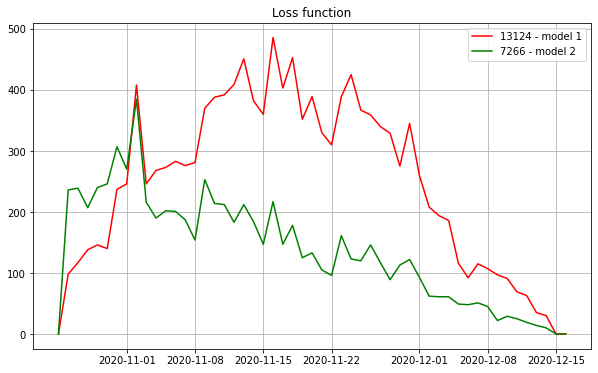

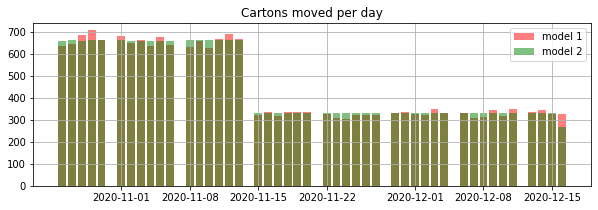



| Method   | Loss function   | percentage   |
|----------+-----------------+--------------|
| Model 1  | 13124           | 5.04%        |
| Model 2  | 7266            | 2.79%        |
|          | improvement     | 44.64%       |


In [50]:
print("\n ------------------------------------------------------------------------------------------- \n")
start_date = '26-10-2020'
transport_size = np.ones((45,), dtype=int)
for i in range(0,17):
    transport_size[i] = 2
for i in range(17,45):
    transport_size[i] = 1
compare_two_models_4(solution_1,df_results,start_date,transport_size, transport_size)

# transport_size2 = np.ones((31,), dtype=int)
# for i in range(0,31):
#     transport_size2[i] = 2
# transport_size2 = transport_size2[:29]
# transport_size2[0] = 3
# transport_size2[1] = 3
# transport_size2[2] = 3
# transport_size2[3] = 3

# compare_two_models_4(solution_1,df_results,start_date,transport_size2, transport_size2)

loss function count time: 5.63 s
loss function count time: 5.63 s


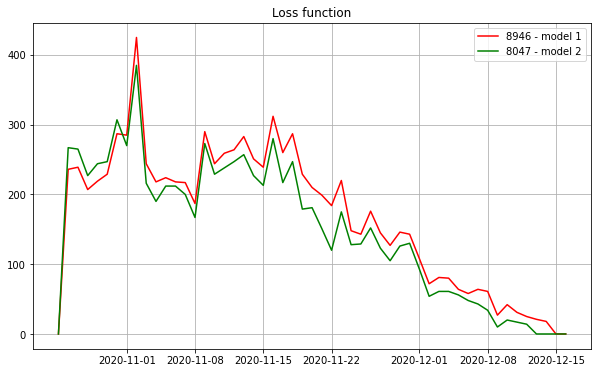

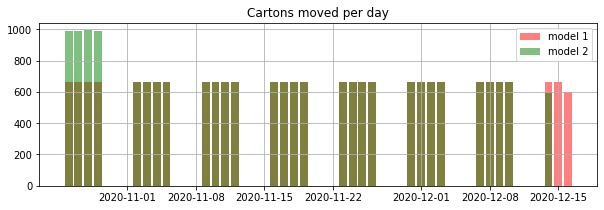

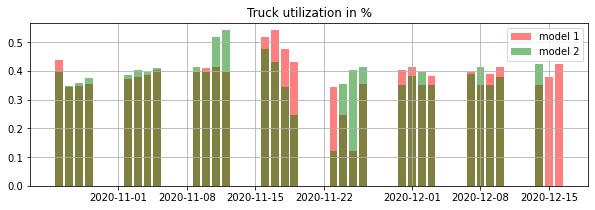



| Method   | Loss function   | percentage   |
|----------+-----------------+--------------|
| Model 1  | 8946            | 3.43%        |
| Model 2  | 8047            | 3.09%        |
|          | improvement     | 10.05%       |


In [34]:
compare_two_models_4(df_results,df_results,start_date,transport_size, transport_size2)